In [34]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

from cryptic_rnn import *

# Functions

# RNN setup

In [35]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def fully_trained_rnns(res):

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
   
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:], 'test_acc': acc_test[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc = fully_trained.test_acc
    fully_trained_idx = fully_trained.index
    
    final_accs = pd.DataFrame({'train_acc': acc_train_p[-1,:], 'test_acc_p': acc_test_p[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc_p = fully_trained.test_acc_p
    fully_trained_idx_p = fully_trained.index
    
    ft_idx = list(fully_trained_idx_p.intersection(fully_trained_idx))
    
    ft_cue_dicts = [cue_dicts[i] for i in ft_idx]
    ft_tests = [tests[i] for i in ft_idx]
    ft_mods = [mods[i] for i in ft_idx]
    ft_mods_p = [mods_p[i] for i in ft_idx]
    
    return ft_mods, ft_mods_p, ft_tests, ft_cue_dicts, ft_test_acc, ft_test_acc_p 
    

def run_exp(trainseqs_old , testseqs_old1, testseqs_old2, cue_dict,xavier_gain):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset1, testset2], epochs, hidden_size)

    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test1': testset1, 'test2': testset2}

def run_plot(trainseqs, testseqs1, testseqs2, cue_dict, xavier_gain):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs1,testseqs2, cue_dict, xavier_gain) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list1 = [r['acc'][:,1] for r in res]
    acc_test_list2 = [r['acc'][:,2] for r in res]
    loss_list = [r['loss'] for r in res]
 
    tests1 = [r['test1'] for r in res]
    tests2 = [r['test2'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test1 = np.array([r['acc'][:,1] for r in res]).T
    acc_test2 = np.array([r['acc'][:,2] for r in res]).T
    mods = [r['mod'] for r in res]
    
    _, _, alldfs = predcorr(mods, tests1, hidden_size, plot_corr = True)
    _, _, alldfs = predcorr(mods, tests2, hidden_size, plot_corr = True)
    
    plotNNs([losses], [acc_train, acc_test1, acc_test2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc1': acc_test1[-1,:], 'test_acc2': acc_test2[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc1 = fully_trained['test_acc1'].mean() 
    fully_trained_test_acc_std1 = fully_trained['test_acc1'].std()
    fully_trained_test_acc2 = fully_trained['test_acc2'].mean() 
    fully_trained_test_acc_std2 = fully_trained['test_acc2'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests1 = [tests1[i] for i in fully_trained_idx]
    ft_tests2 = [tests2[i] for i in fully_trained_idx]
    ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
    ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        _, dfs1, alldfs = predcorr(ft_mods, ft_tests1, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs2, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
   
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_test1': acc_test1[-1,:], 'acc_test2': acc_test2[-1,:]})
    
    return {'res':res,'mods':mods ,'dfs1': dfs1, 'dfs2': dfs2,\
            'tests1': tests1, 'tests2': tests2,'cue_dicts': cue_dicts, 'acc_df':acc_df }


In [37]:
def generate_neg_trials(op, input_ids, init_values, cue_dict):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([('-',init),
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_neg_other(op, inputs, cue_dict):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [('-',inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_pos_trials(op, input_ids, init_values, cue_dict):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([('+',init),
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_pos_other(op, inputs, cue_dict):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [('+',inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[1])
        j = map_syms.index(eval(trial)[3])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


In [38]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 15
learningRate = 0.005

## running params
epochs = 12
num_sims = 8

# 
xavier_gain = 0.0001

# Experiments

Final accuracy against ratio of other/self



In [43]:
add = '+'
sub = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)
print(neg_primitives)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 11, 'B': 12, 'C': 2, 'D': 6}
[['A', '=', 11], ['B', '=', 12], ['C', '=', 2], ['D', '=', 6]]
[[('-', 'A'), '=', -11], [('-', 'B'), '=', -12], [('-', 'C'), '=', -2], [('-', 'D'), '=', -6]]
[[('+', 'A'), '=', 11], [('+', 'B'), '=', 12], [('+', 'C'), '=', 2], [('+', 'D'), '=', 6]]


trainseqs  [[('+', 'A'), ('+', 'B'), '=', 23], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'D'), '=', 8], [('+', 'D'), ('+', 'A'), '=', 17], [('-', 'A'), ('-', 'B'), '=', -23], [('-', 'B'), ('-', 'C'), '=', -14], [('-', 'C'), ('-', 'D'), '=', -8], [('-', 'D'), ('-', 'A'), '=', -17], [('+', 'A'), '=', 11], [('+', 'B'), '=', 12], [('+', 'C'), '=', 2], [('+', 'D'), '=', 6], [('-', 'A'), '=', -11], [('-', 'B'), '=', -12], [('-', 'C'), '=', -2], [('-', 'D'), '=', -6]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 22], [('+', 'A'), ('+', 'C'), '=', 13], [('+', 'A'), ('+', 'D'), '=', 17], [('+', 'B'), ('+', 'A'), '=', 23], [('+', 'B'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'D'), '=', 18], [('+', 'C'), ('+', 'A'), '=', 13], [('+', 'C'), ('+', 'B'), '=', 14], [('+', 'C'), ('+', 'C'), '=', 4], [('+', 'D'), ('+', 'B'), '=', 18], [('+', 'D'), ('+', 'C'), '=', 8], [('+', 'D'), ('+', 'D'), '=', 12]]
run time:  5.246607983112336
1


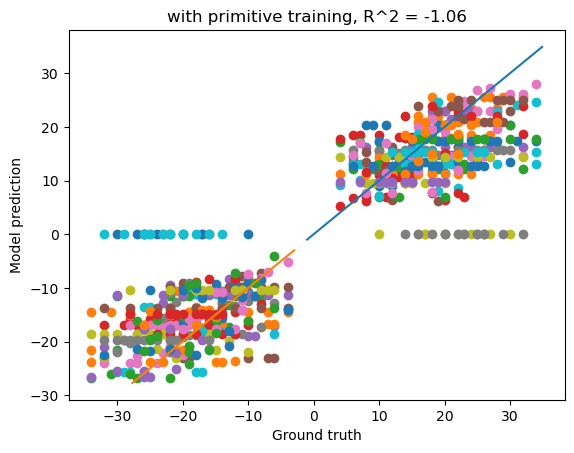

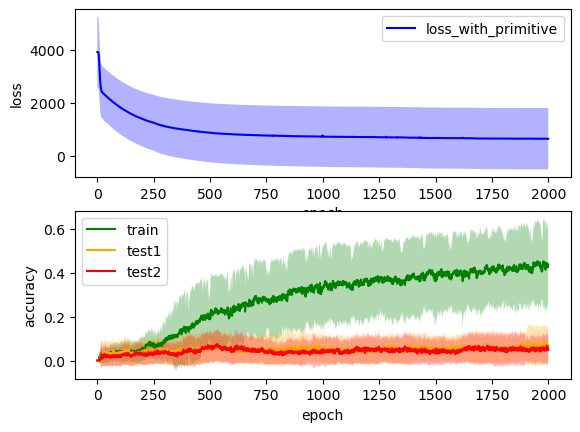

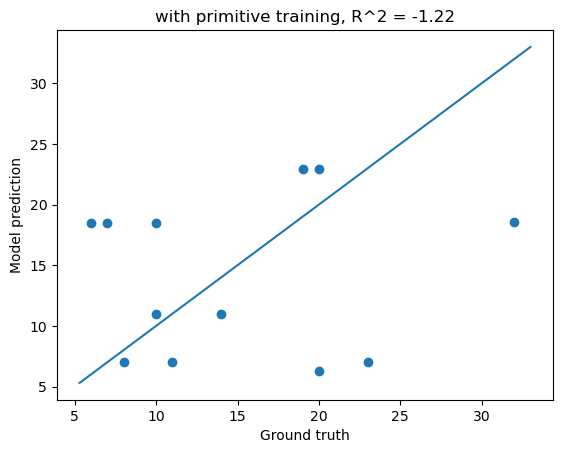

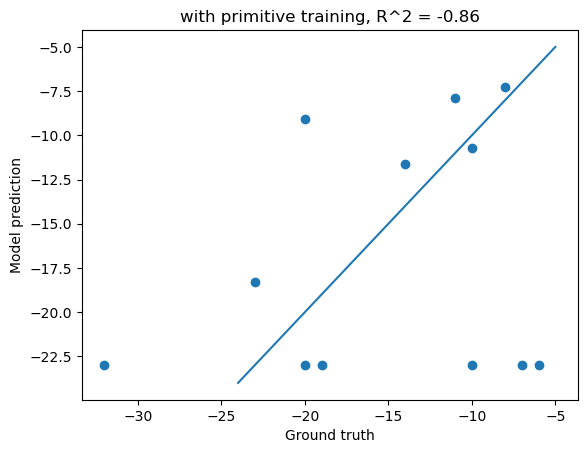

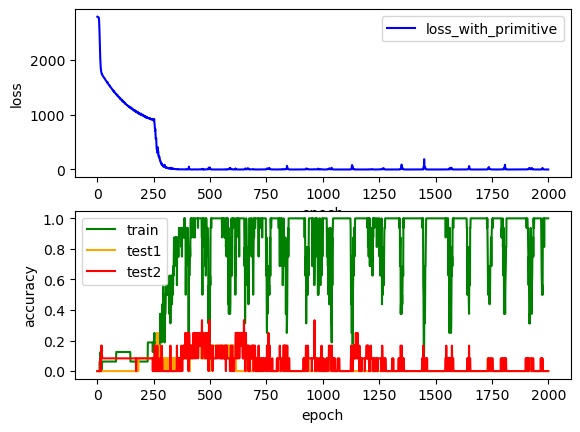

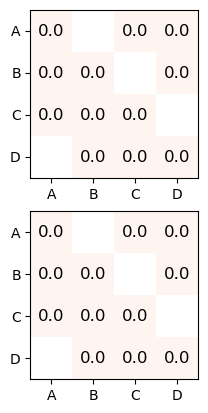

In [46]:
epochs = 2000
num_sims = 32
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_pos_other(add, all_syms, cue_dict)+ generate_neg_other(sub, all_syms, cue_dict)+ pos_primitives + neg_primitives
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 23], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'D'), '=', 8], [('+', 'D'), ('+', 'A'), '=', 17], [('-', 'A'), ('-', 'B'), '=', -23], [('-', 'B'), ('-', 'C'), '=', -14], [('-', 'C'), ('-', 'D'), '=', -8], [('-', 'D'), ('-', 'A'), '=', -17], ['A', '=', 11], ['B', '=', 12], ['C', '=', 2], ['D', '=', 6], [('+', 'A'), '=', 11], [('+', 'B'), '=', 12], [('+', 'C'), '=', 2], [('+', 'D'), '=', 6], [('-', 'A'), '=', -11], [('-', 'B'), '=', -12], [('-', 'C'), '=', -2], [('-', 'D'), '=', -6]]
testseqs  [['A', ('+', 'A'), '=', 22], ['A', ('+', 'B'), '=', 23], ['A', ('+', 'C'), '=', 13], ['A', ('+', 'D'), '=', 17], ['B', ('+', 'A'), '=', 23], ['B', ('+', 'B'), '=', 24], ['B', ('+', 'C'), '=', 14], ['B', ('+', 'D'), '=', 18], ['C', ('+', 'A'), '=', 13], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 4], ['C', ('+', 'D'), '=', 8], ['D', ('+', 'A'), '=', 17], ['D', ('+', 'B'), '=', 18], ['D', ('+', 'C'), '=', 8], ['D', ('+', 'D'), '=', 12]]
run 

ValueError: '+' is not in list

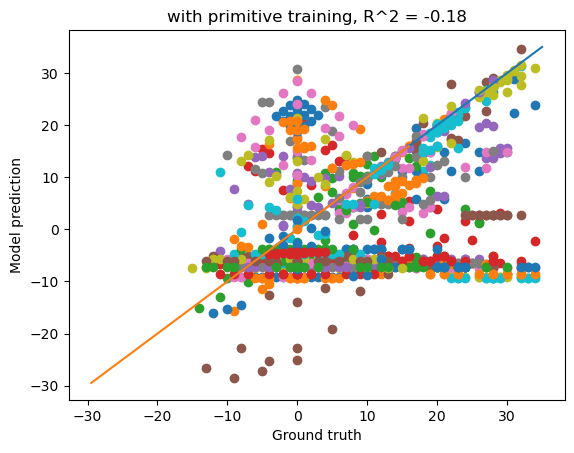

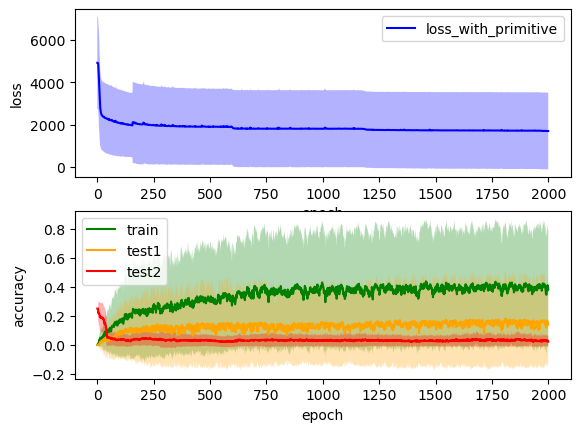

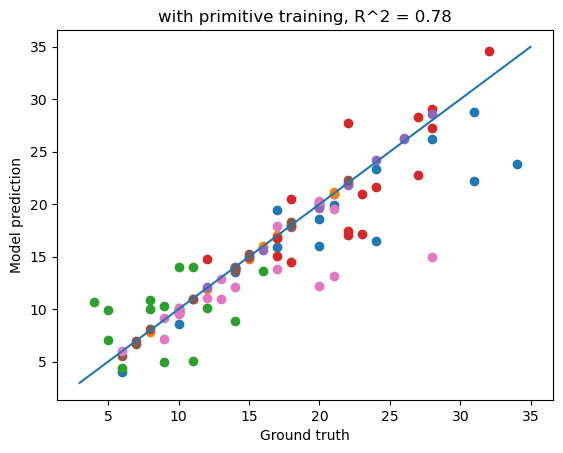

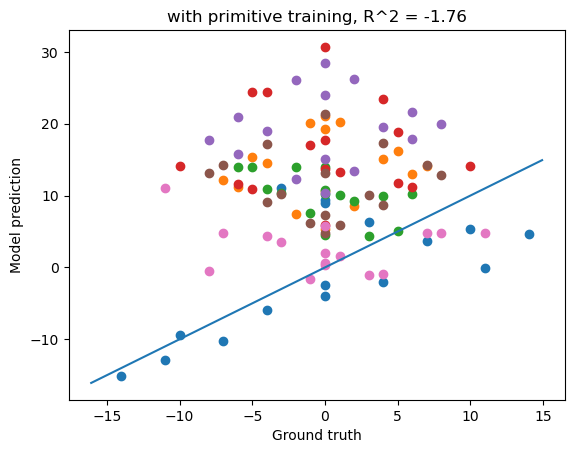

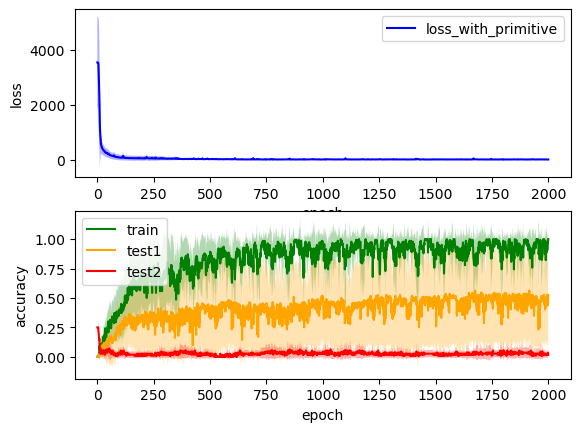

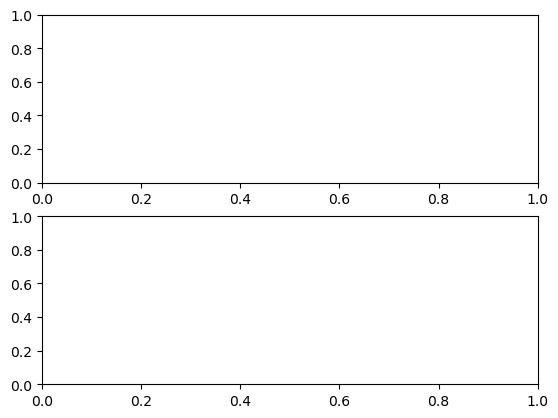

In [45]:
epochs = 2000
num_sims = 32
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_pos_other(add, all_syms, cue_dict)+ generate_neg_other(sub, all_syms, cue_dict)+ primitives + pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

In [5]:
add = '+'
sub = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)
print(neg_primitives)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 10, 'B': 8, 'C': 6, 'D': 14}
[['A', '=', 10], ['B', '=', 8], ['C', '=', 6], ['D', '=', 14]]
[[('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
[[('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14]]


# Run

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', -4], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -6], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', -2], ['C'

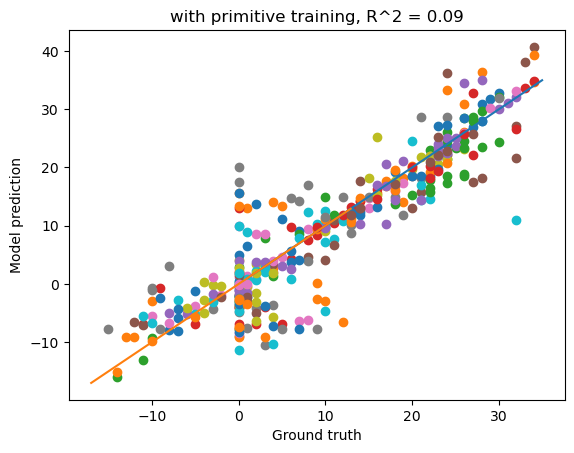

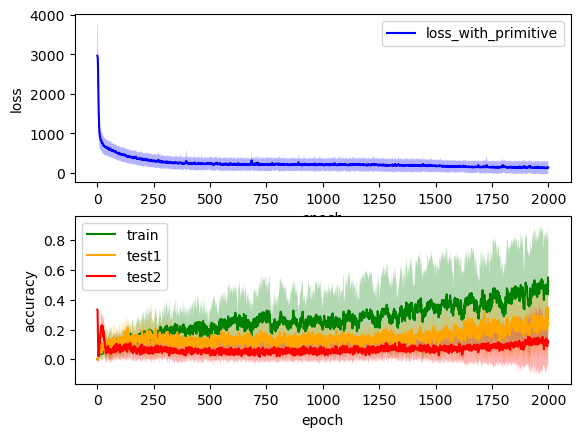

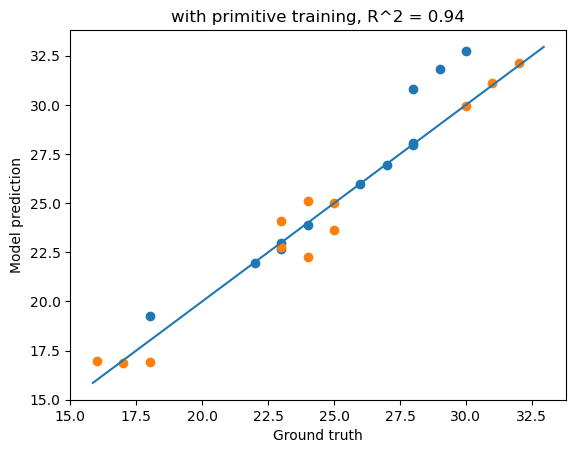

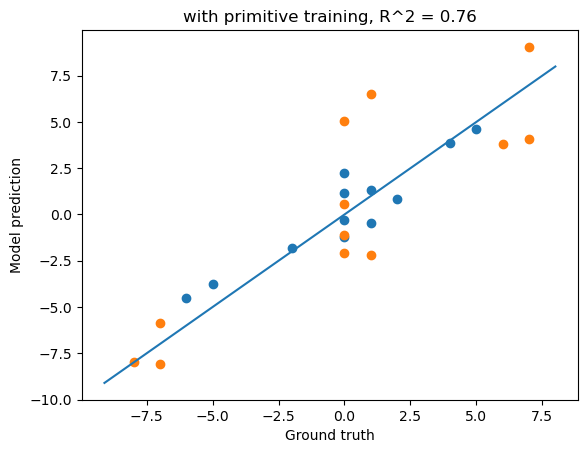

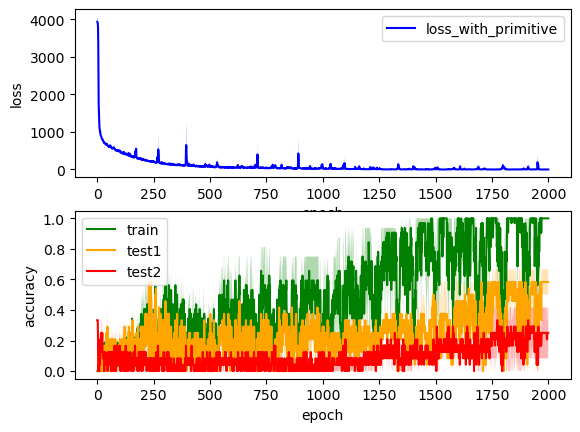

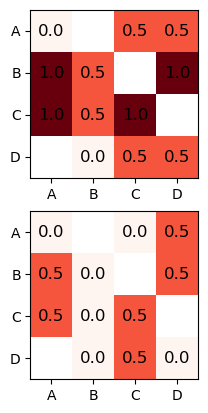

In [10]:
epochs = 2000
num_sims = 16
xavier_gain = 0.0001
hidden_size = 20

trainseqs = generate_other(add, all_syms, cue_dict) + generate_other(sub, all_syms, cue_dict)+ pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
print('testseqs ', testseqs_sub)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', -4], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -6], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', -2], ['C'

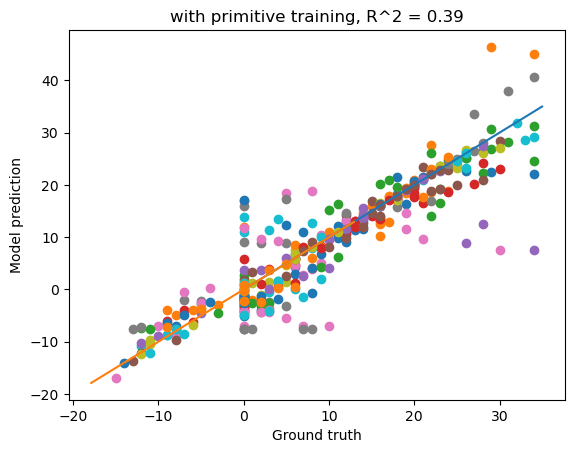

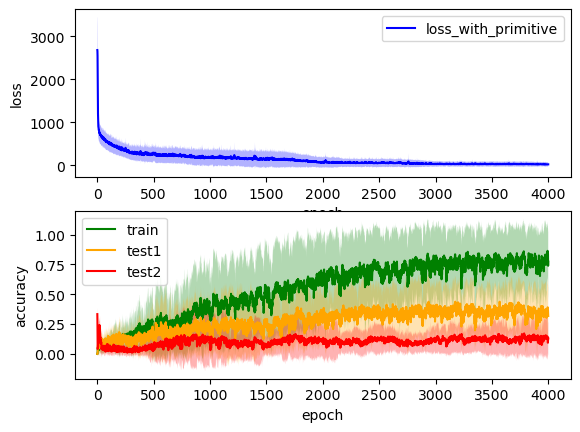

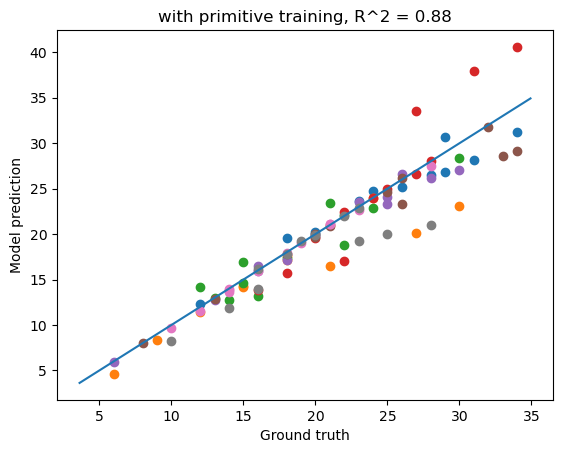

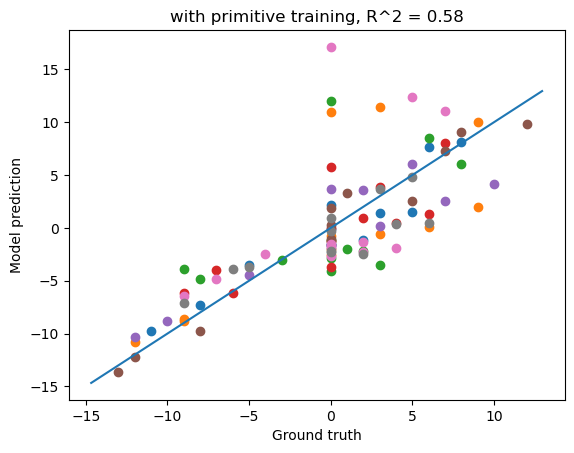

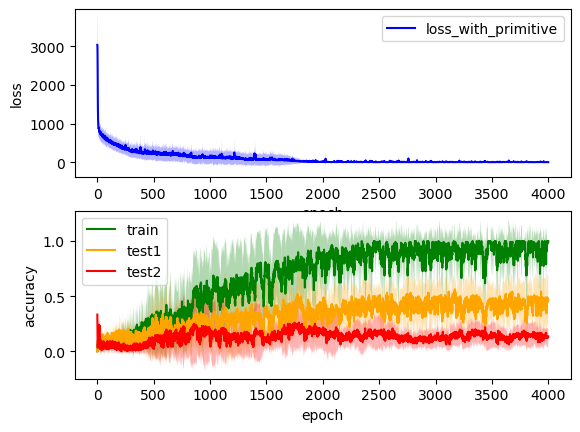

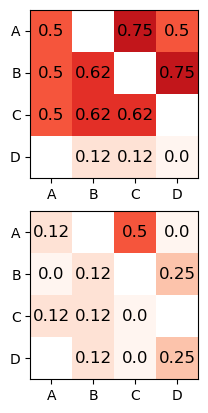

In [12]:
epochs = 4000
num_sims = 16
xavier_gain = 0.0001
hidden_size = 30

trainseqs = generate_other(add, all_syms, cue_dict) + generate_other(sub, all_syms, cue_dict)+ pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
print('testseqs ', testseqs_sub)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', -4], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -6], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', -2], ['C'

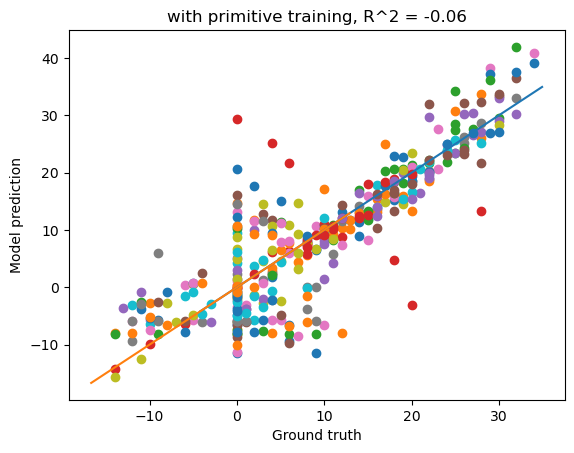

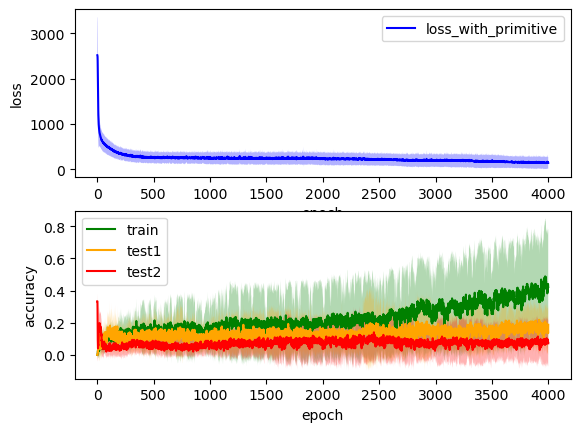

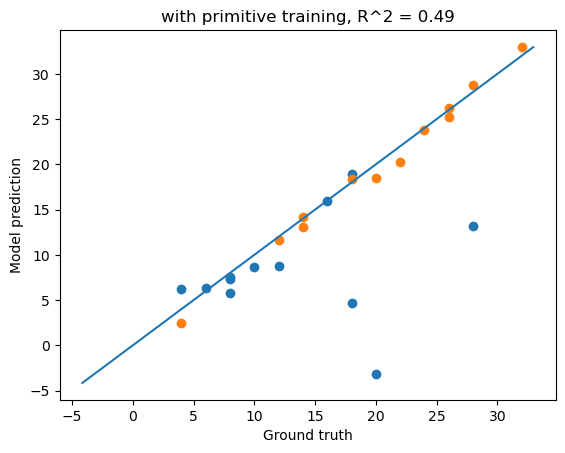

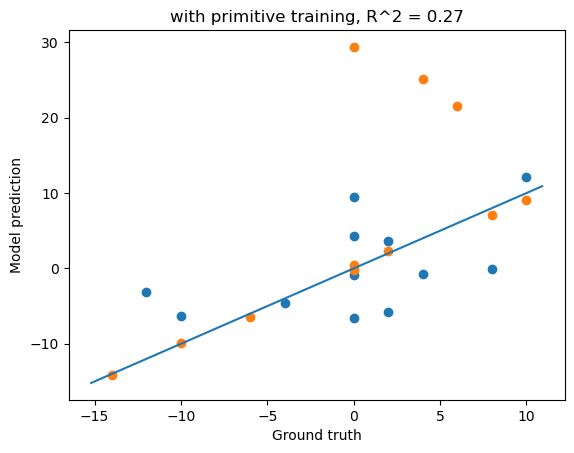

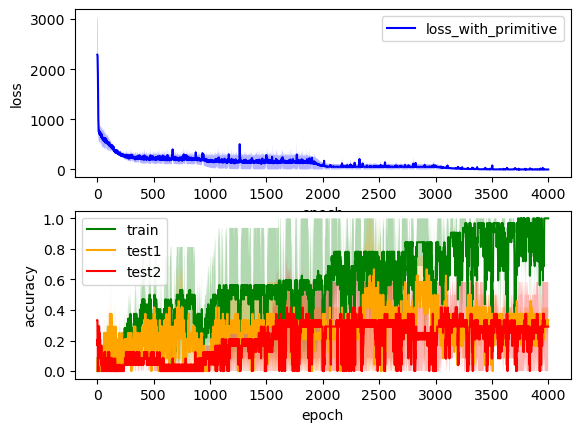

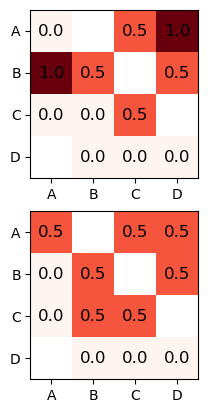

In [13]:
epochs = 4000
num_sims = 16
xavier_gain = 0.0001
hidden_size = 15

trainseqs = generate_other(add, all_syms, cue_dict) + generate_other(sub, all_syms, cue_dict)+ pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
print('testseqs ', testseqs_sub)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', -4], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -6], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', -2], ['C'

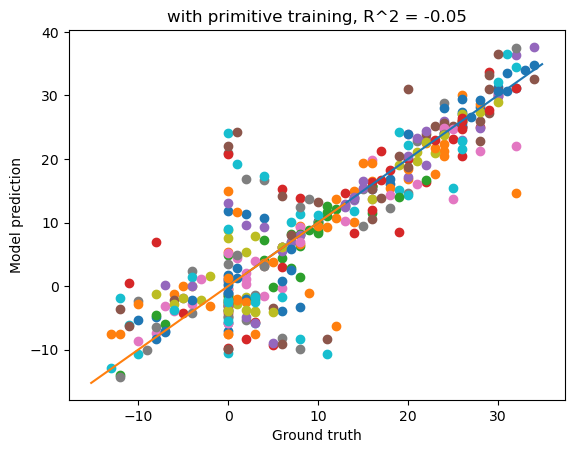

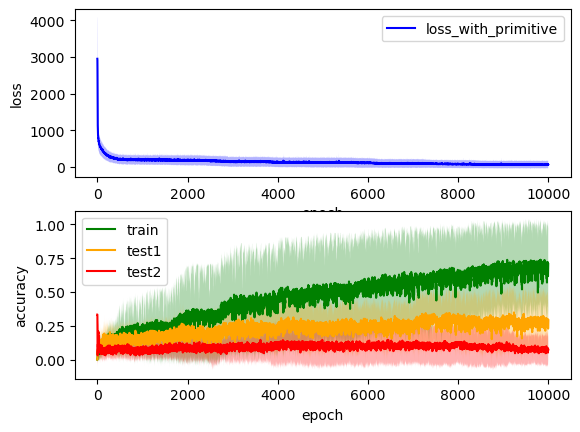

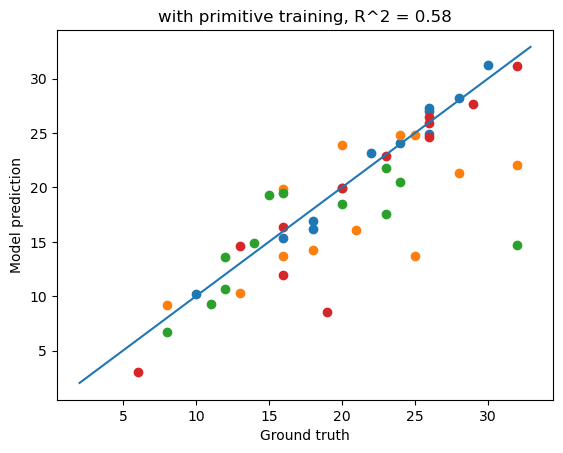

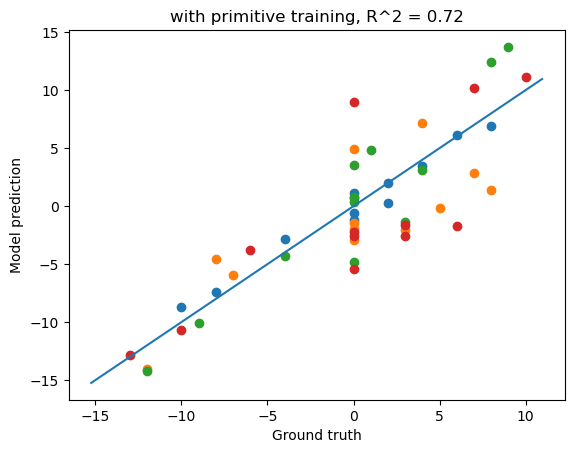

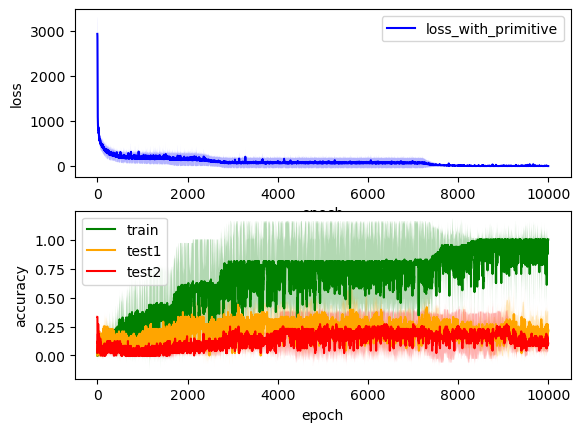

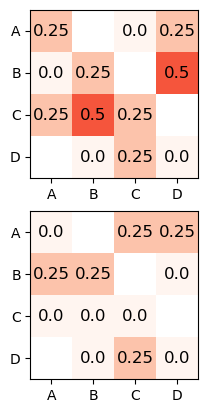

In [14]:
epochs = 10000
num_sims = 16
xavier_gain = 0.0001
hidden_size = 15

trainseqs = generate_other(add, all_syms, cue_dict) + generate_other(sub, all_syms, cue_dict)+ pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
print('testseqs ', testseqs_sub)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], ['A', '=', 10], ['B', '=', 8], ['C', '=', 6], ['D', '=', 14], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', -4], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', -6]

ValueError: need at least one array to concatenate

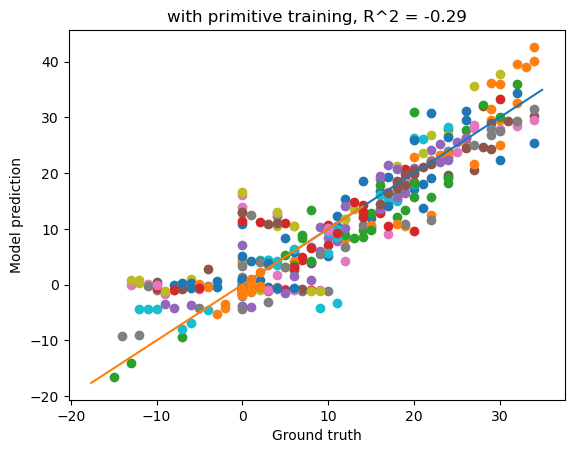

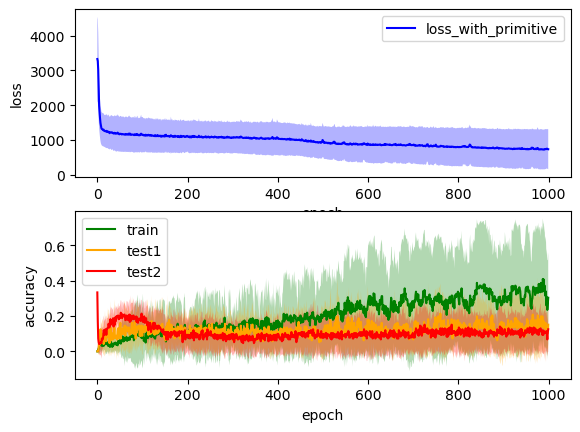

In [11]:
epochs = 1000
num_sims = 16
xavier_gain = 0.0001

trainseqs = generate_other(add, all_syms, cue_dict) + generate_other(sub, all_syms, cue_dict)+ primitives + pos_primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
print('testseqs ', testseqs_sub)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  594.4329356988271
25


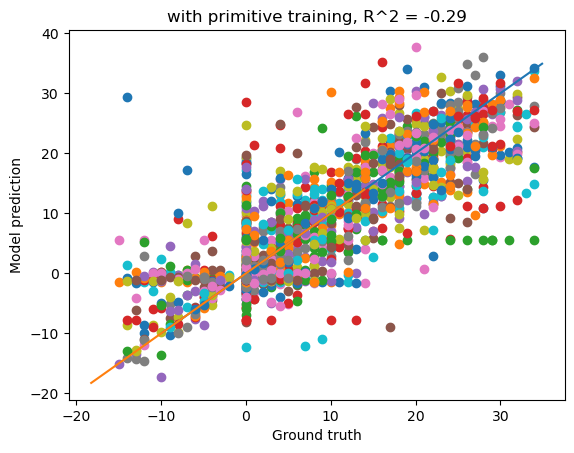

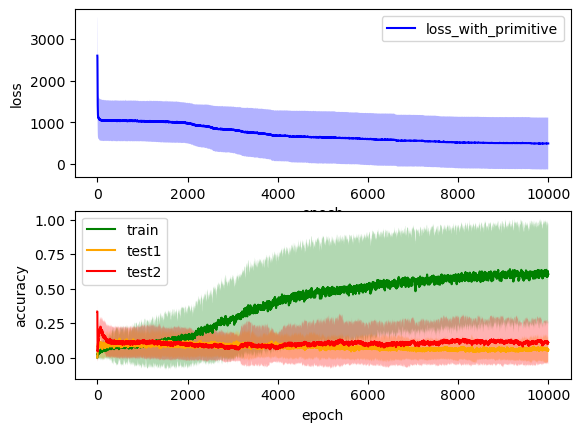

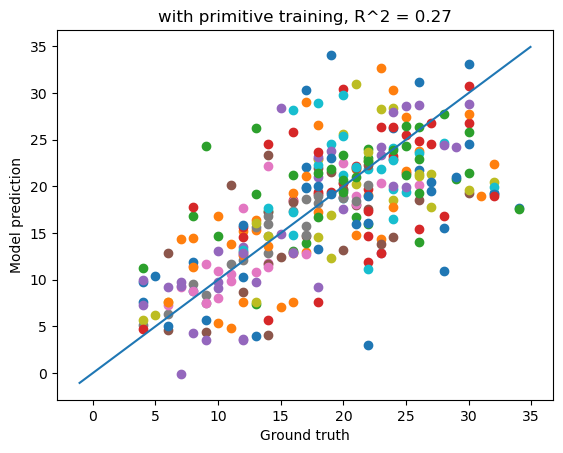

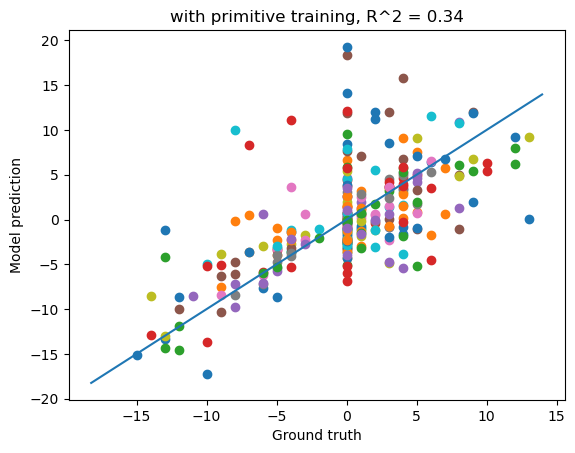

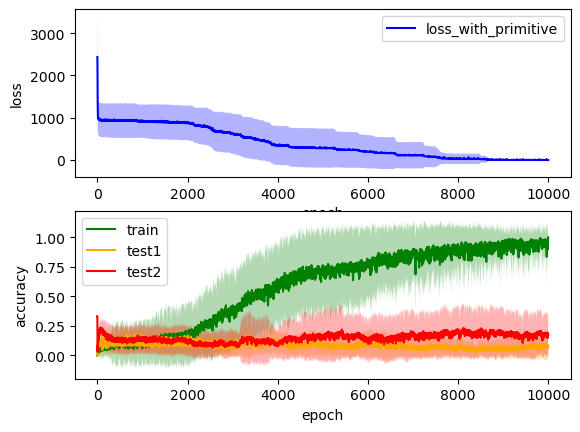

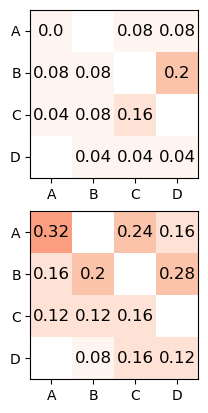

In [40]:
epochs = 10000
num_sims = 64
hidden_size = 20

xavier_gain = 0.001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  4.7572258313496905
3


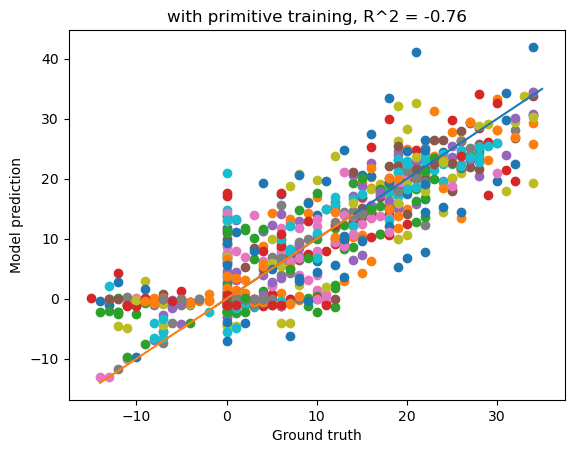

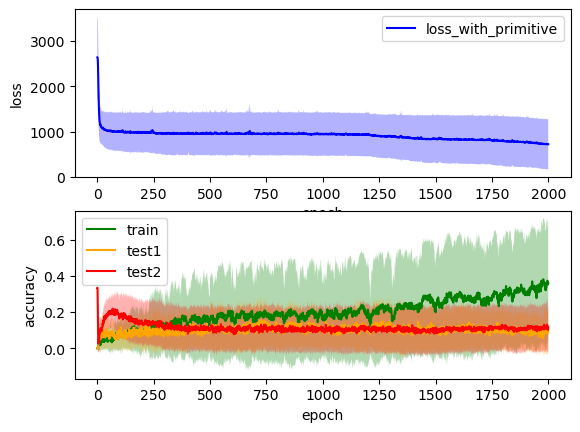

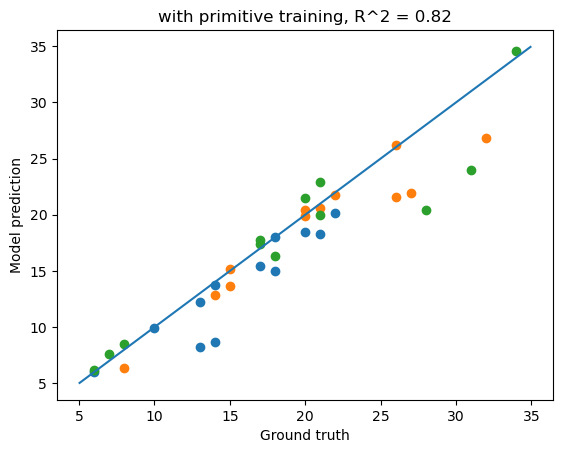

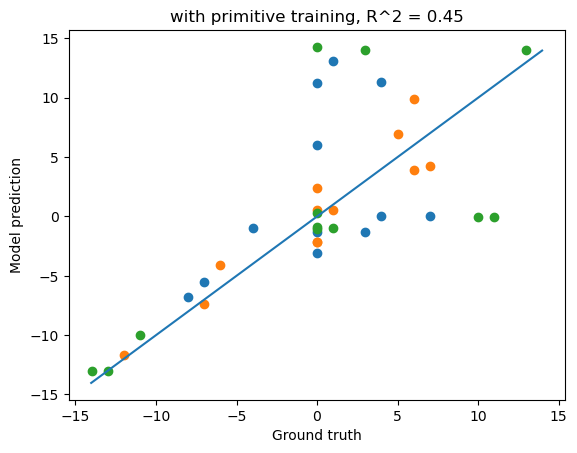

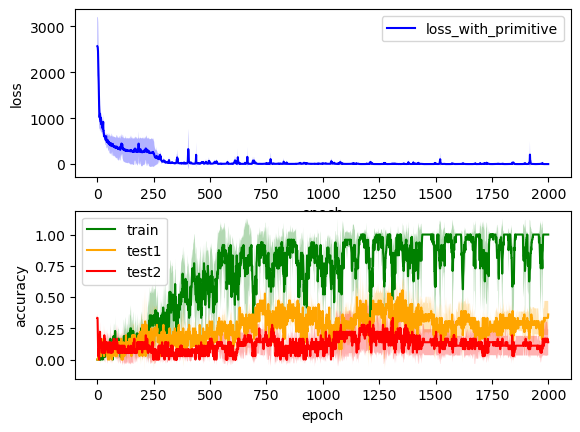

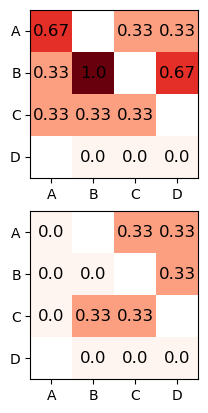

In [41]:
epochs = 2000
num_sims = 32
hidden_size = 30

xavier_gain = 0.001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  5.193333597977956
13


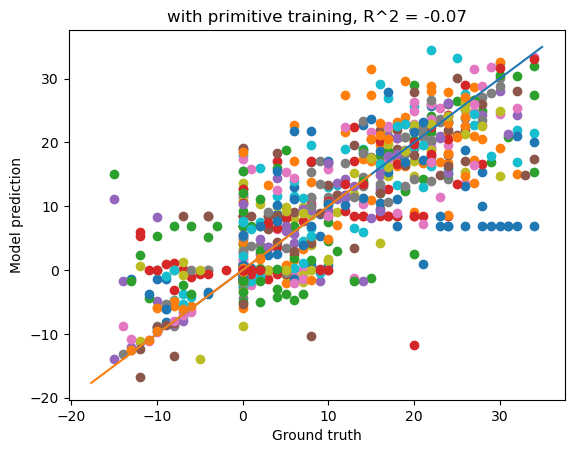

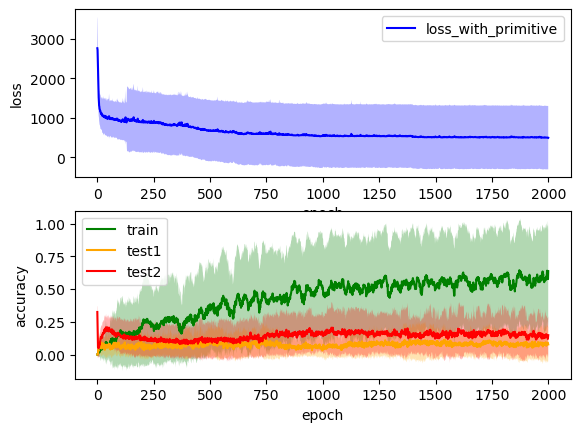

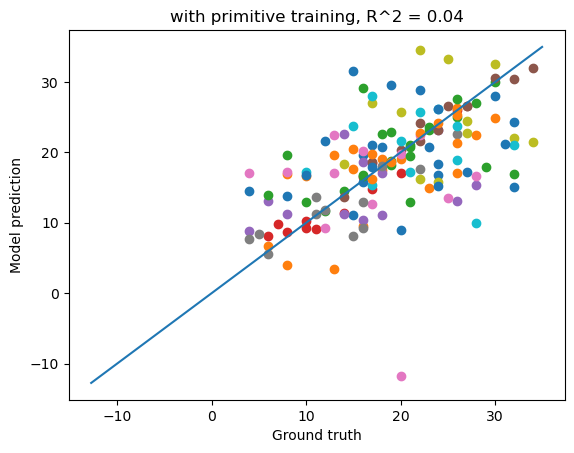

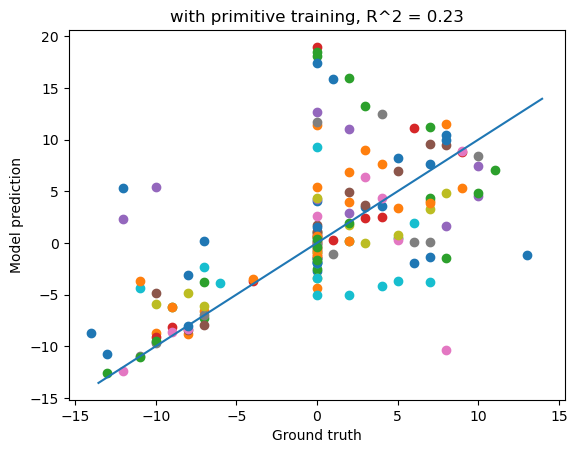

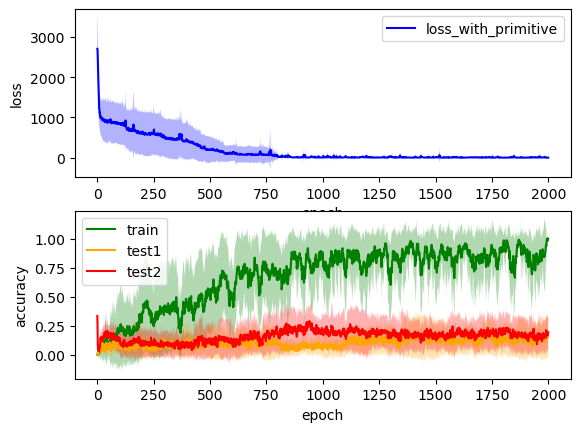

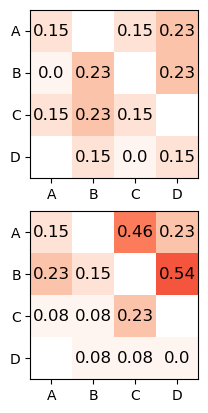

In [42]:
epochs = 2000
num_sims = 32
hidden_size = 30
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  4.688223000367483
7


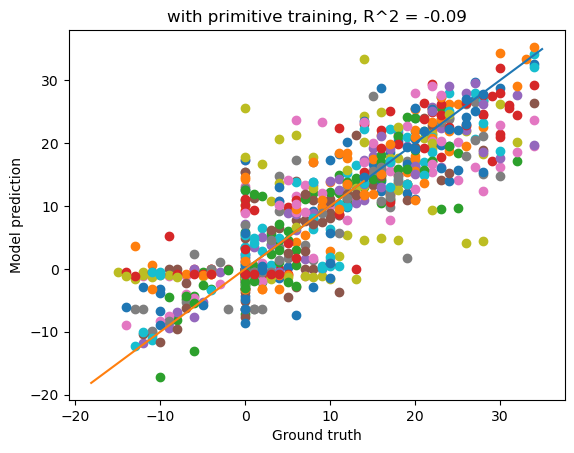

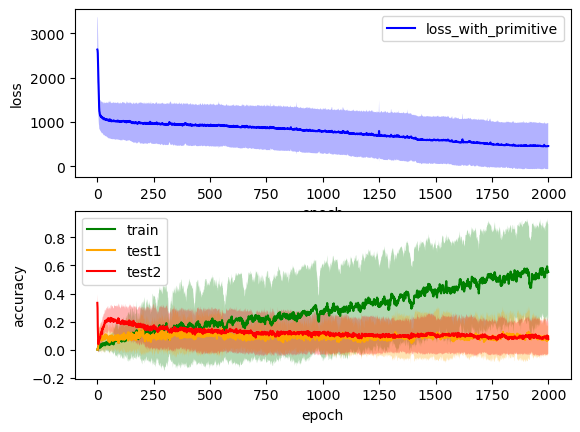

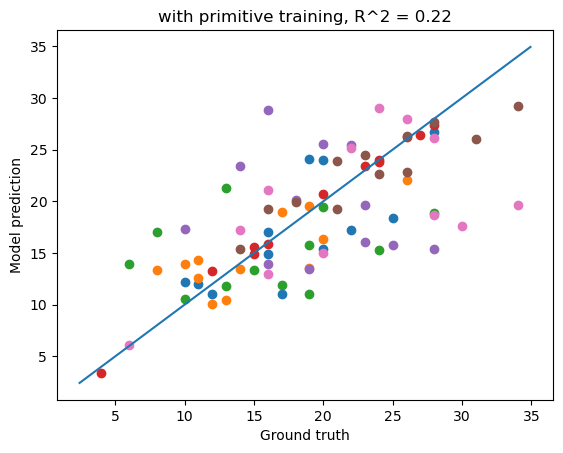

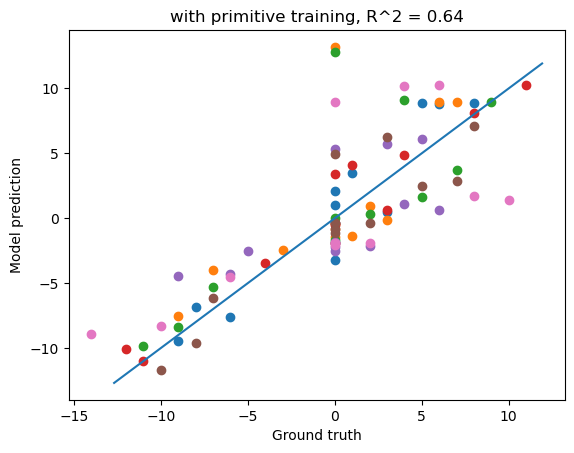

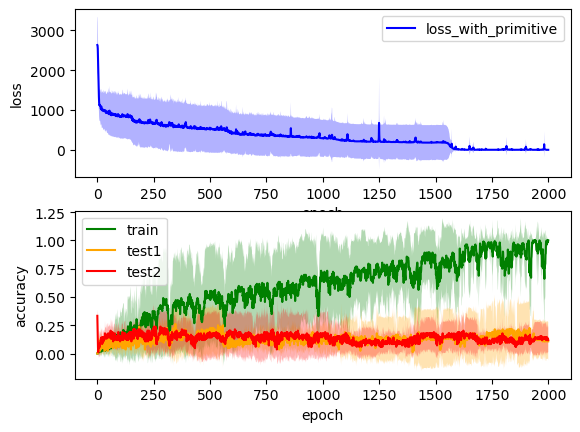

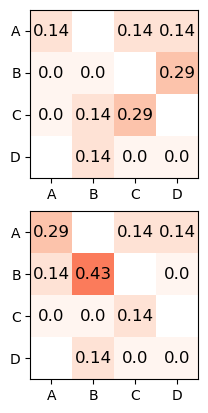

In [43]:
epochs = 2000
num_sims = 32
hidden_size = 40
learningRate = 0.005
xavier_gain = 0.00001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  4.851547686258952
15


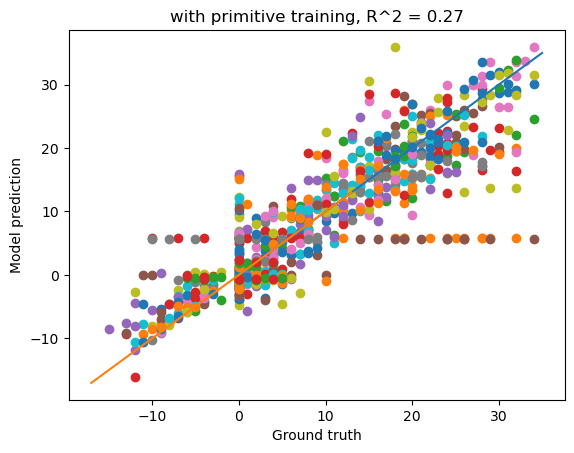

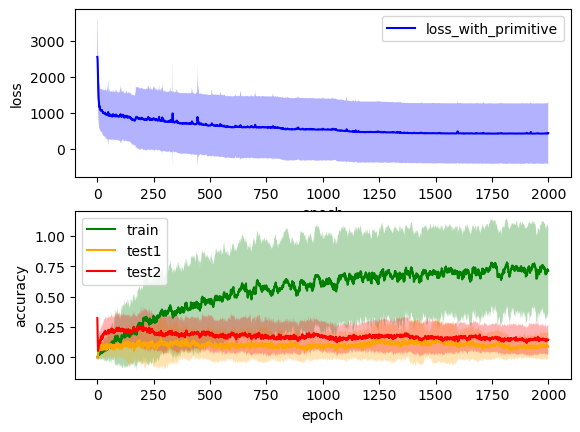

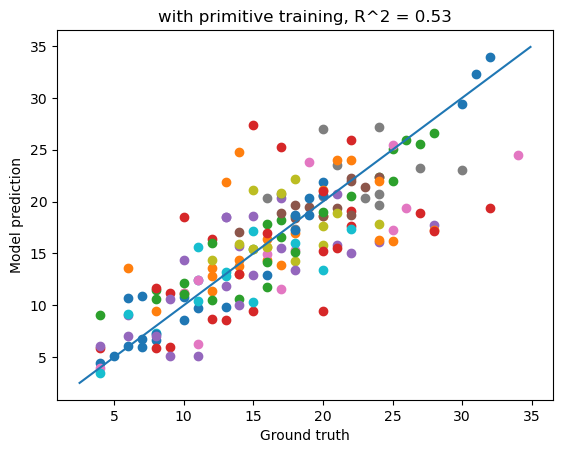

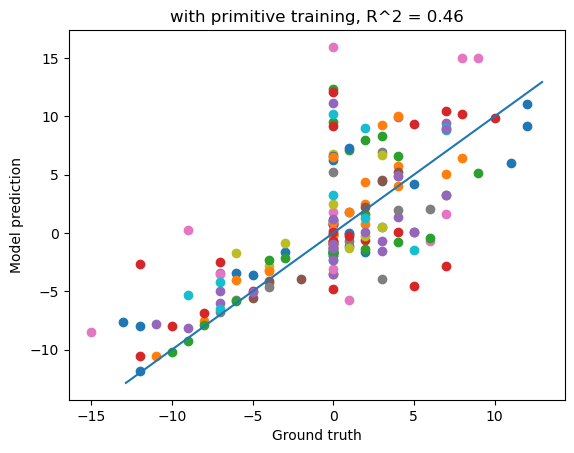

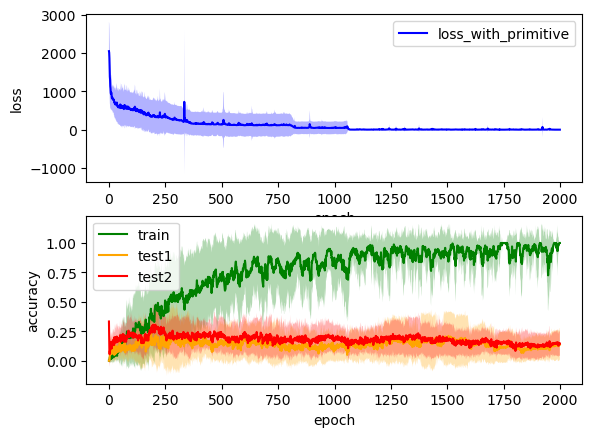

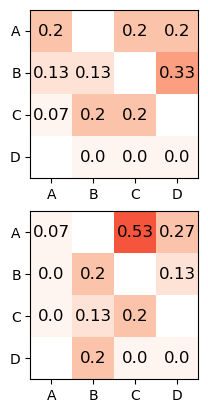

In [44]:
epochs = 2000
num_sims = 32
hidden_size = 80
learningRate = 0.005
xavier_gain = 0.00001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  4.92721129655838
12


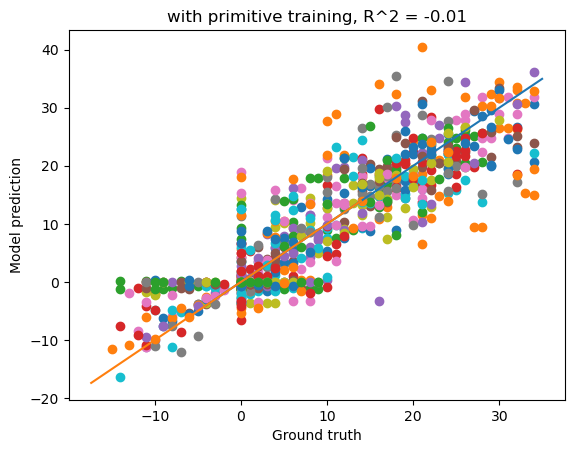

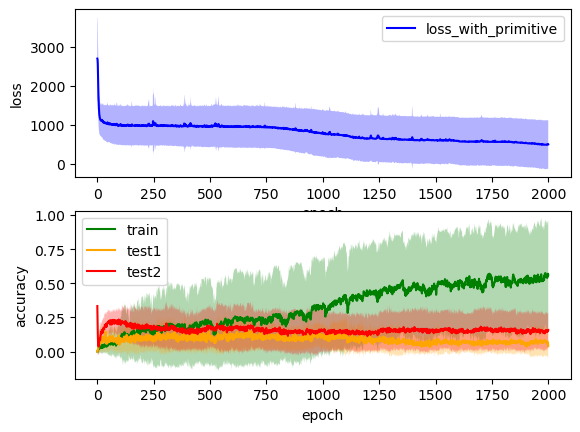

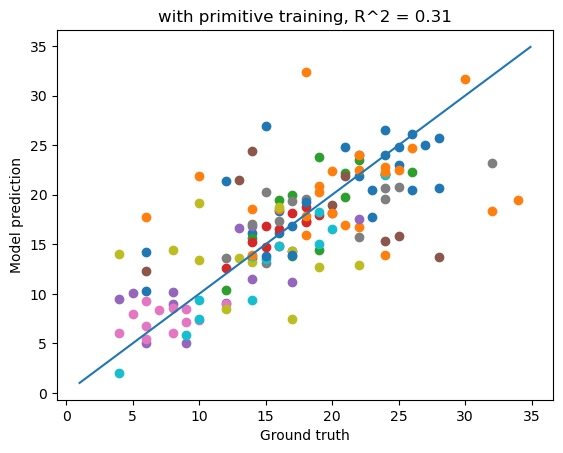

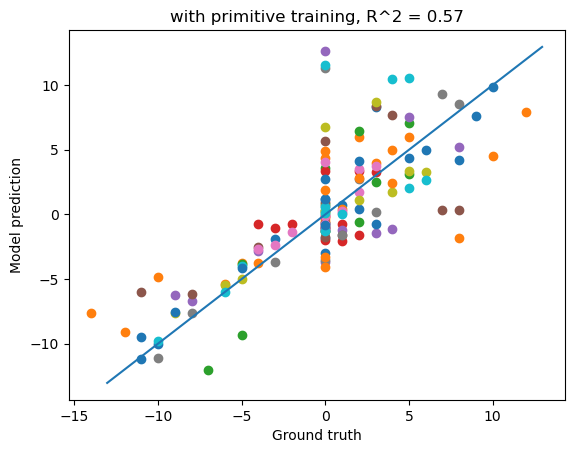

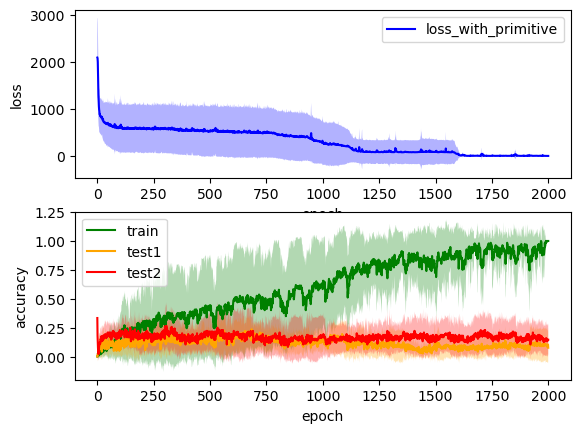

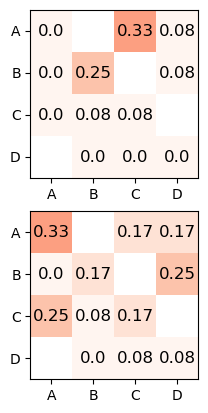

In [45]:
epochs = 2000
num_sims = 32
hidden_size = 40
learningRate = 0.005
xavier_gain = 0.00001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  19.137430437405904
4


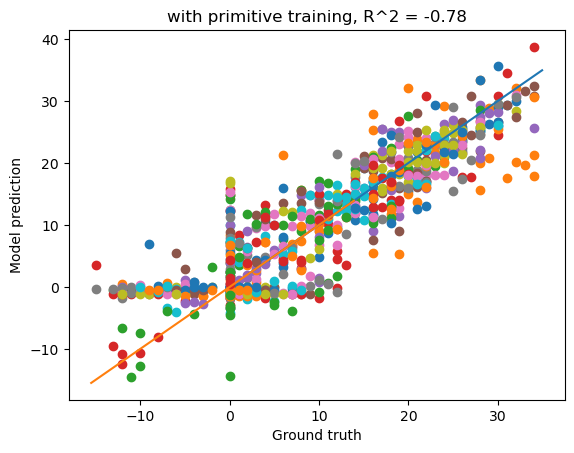

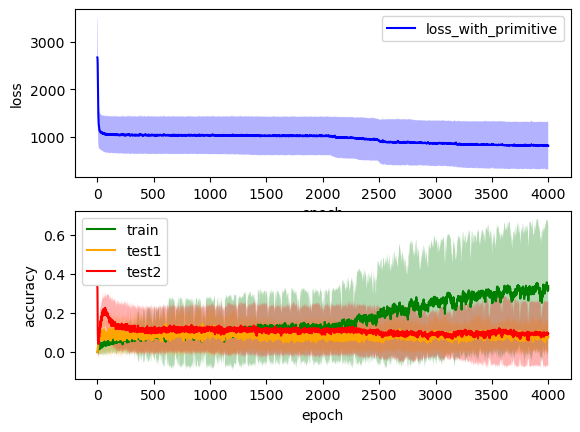

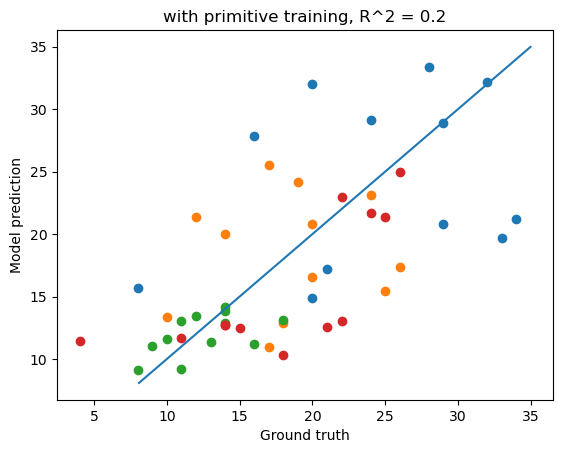

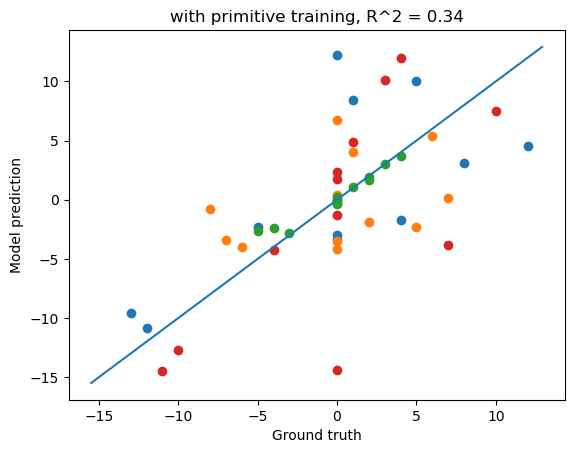

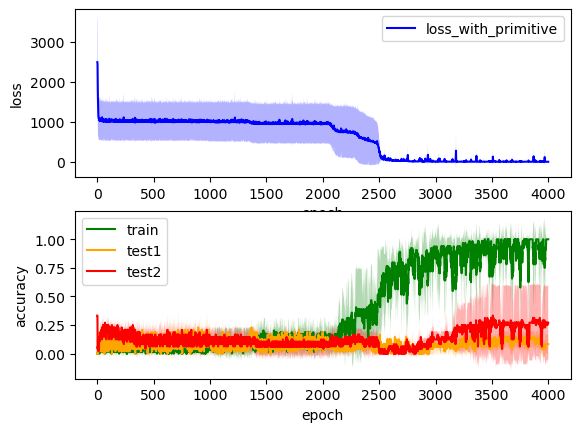

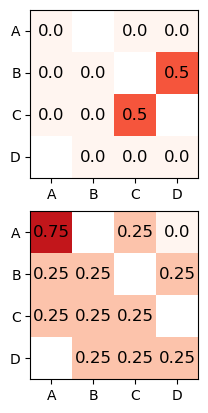

In [46]:
epochs = 4000
num_sims = 32
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.00001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  12.209029797712962
6


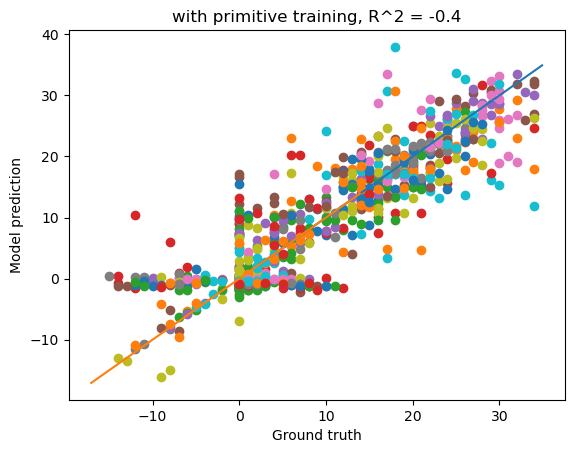

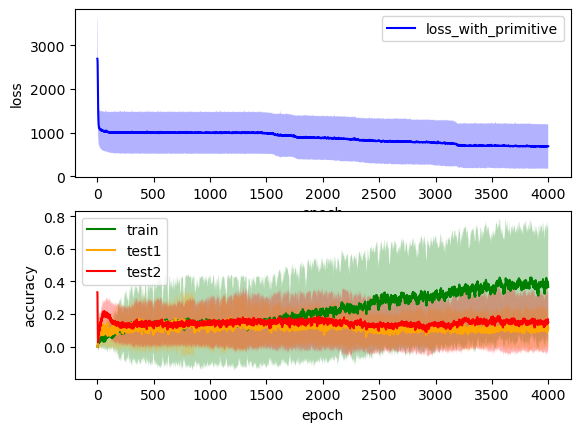

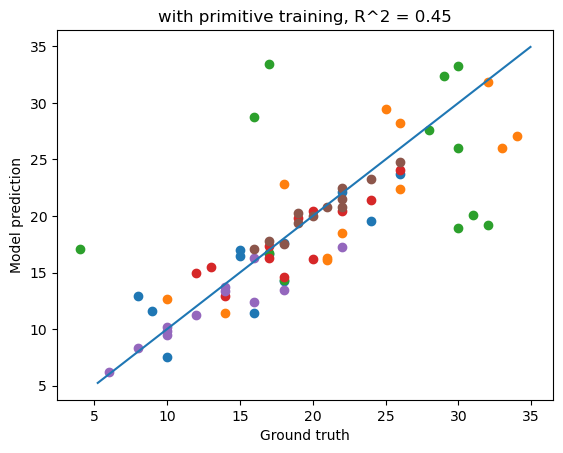

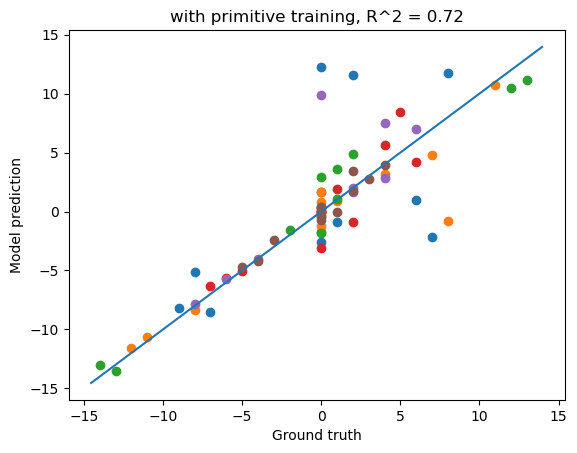

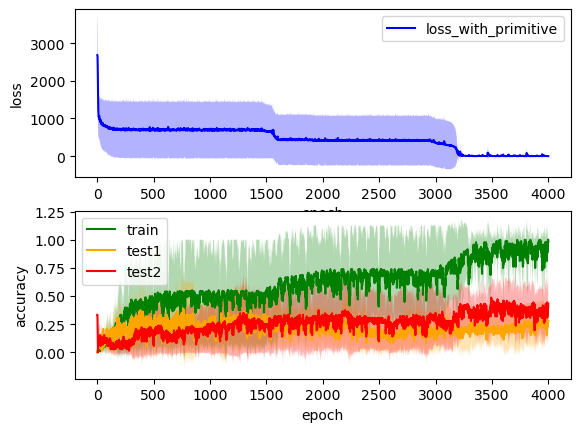

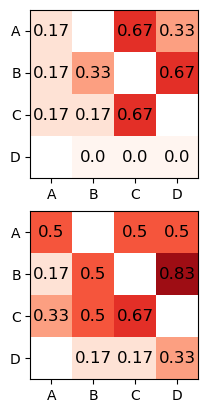

In [47]:
epochs = 4000
num_sims = 32
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  50.89244663317998
11


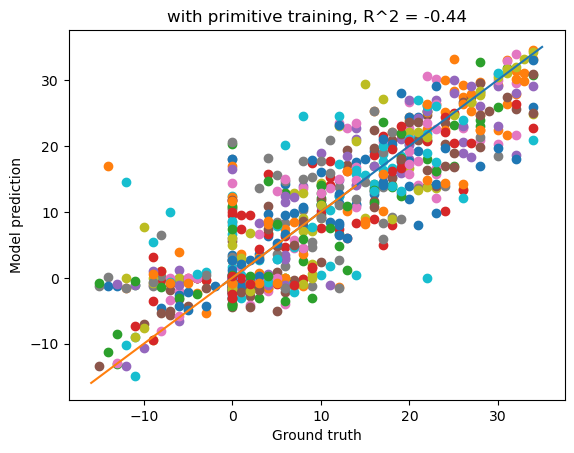

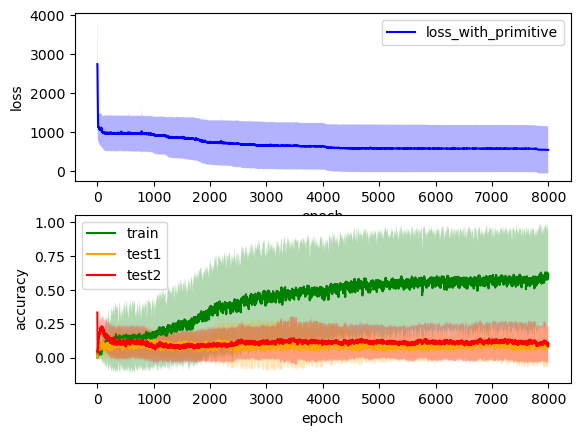

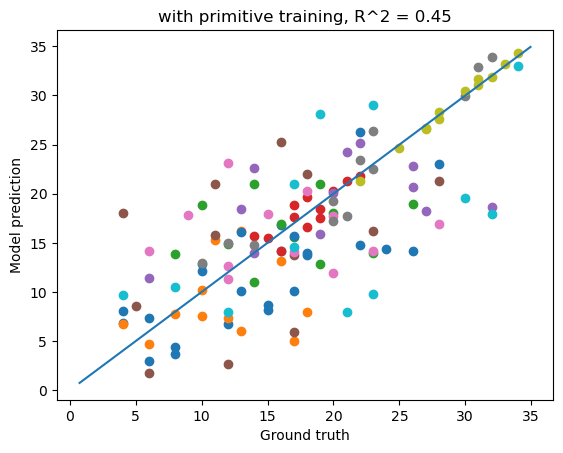

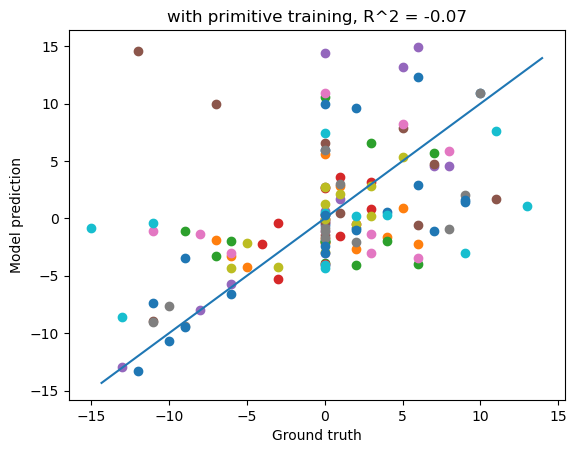

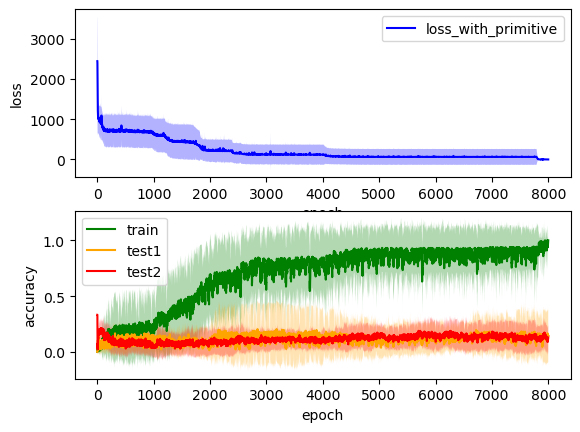

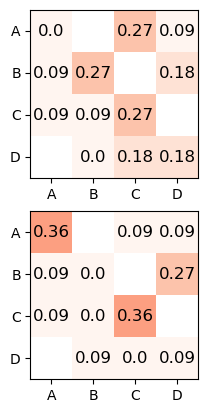

In [49]:
epochs = 8000
num_sims = 32
hidden_size = 30
learningRate = 0.005
xavier_gain = 0.0001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 27], ['C', ('+', 'D'), '=', 21], ['D', ('+', 'A'), '=', 15], ['A', ('-', 'B'), '=', -9], ['B', ('-', 'C'), '=', 3], ['C', ('-', 'D'), '=', 3], ['D', ('-', 'A'), '=', 3], ['A', '=', 6], ['B', '=', 15], ['C', '=', 12], ['D', '=', 9], [('-', 'A'), '=', -6], [('-', 'B'), '=', -15], [('-', 'C'), '=', -12], [('-', 'D'), '=', -9]]
testseqs  [['A', ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 20], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 4], ['B', ('+', 'D'), '=', 19], ['C', ('+', 'A'), '=', 20], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 28], ['D', ('+', 'B'), '=', 19], ['D', ('+', 'C'), '=', 31], ['D', ('+', 'D'), '=', 34]]
run time:  24.895399570465088
1


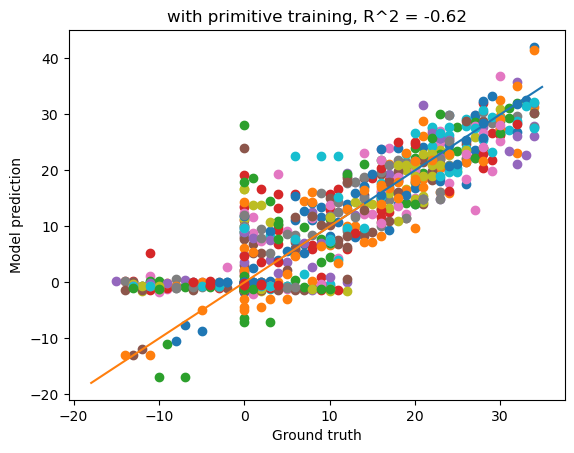

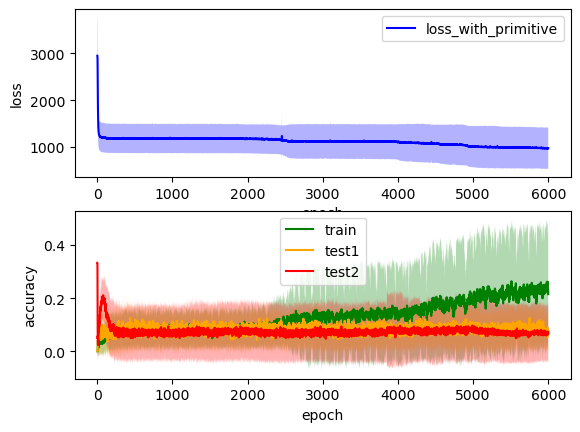

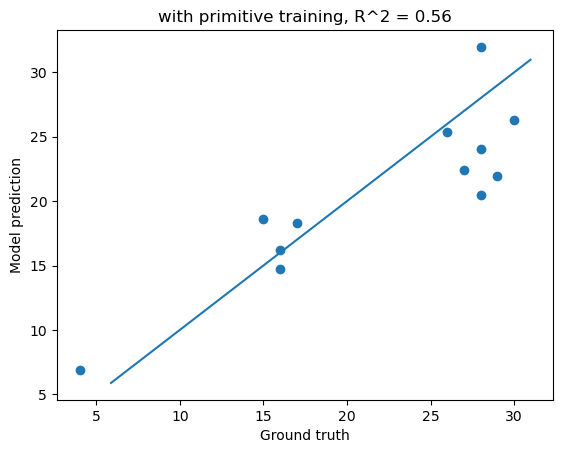

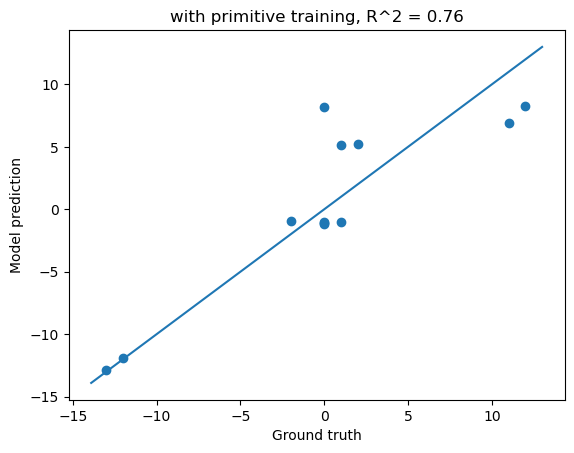

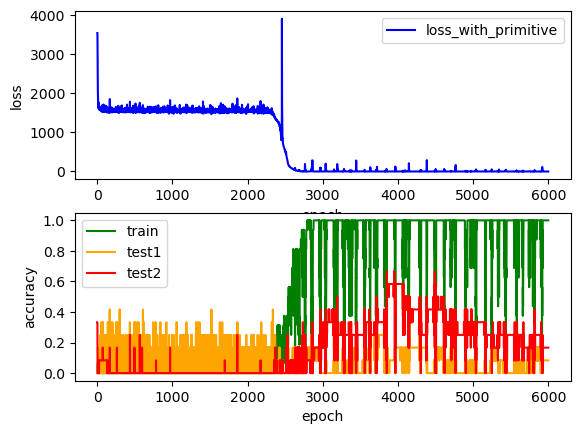

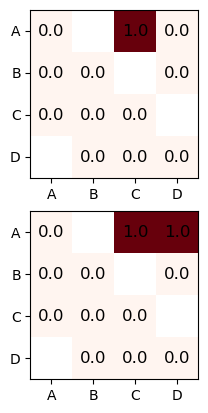

In [50]:
epochs = 6000
num_sims = 32
hidden_size = 15
learningRate = 0.005
xavier_gain = 0.0001

trainseqs = generate_other(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

In [24]:
# just addition

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['A', '=', 10], ['B', '=', 8], ['C', '=', 6], ['D', '=', 14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
run time:  1.8289530515670775
25


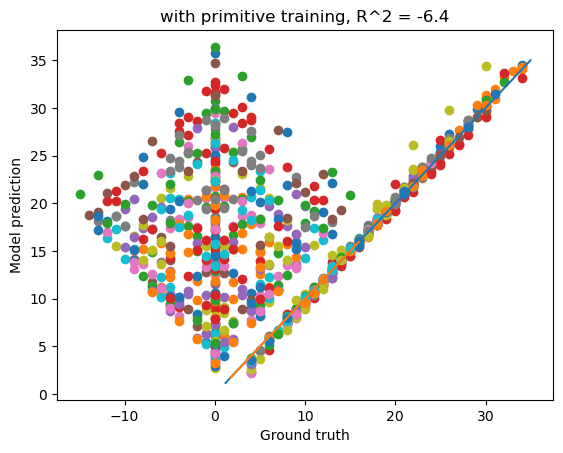

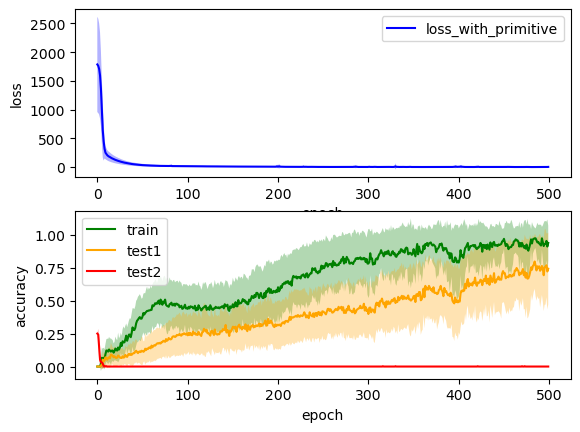

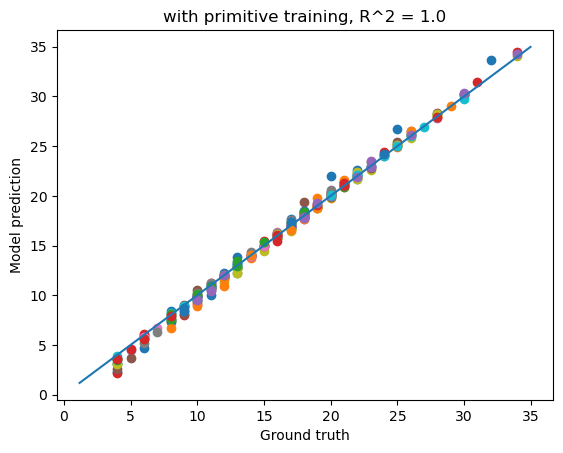

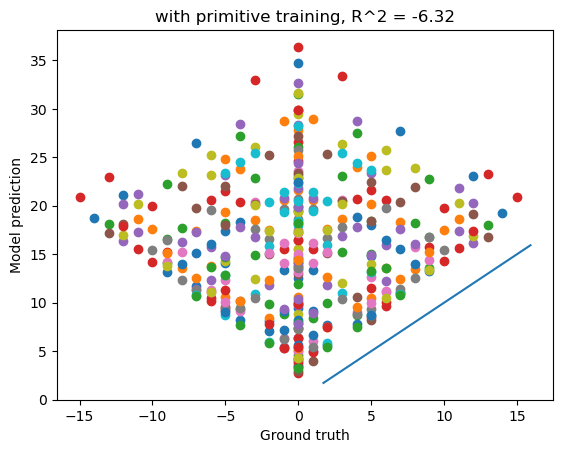

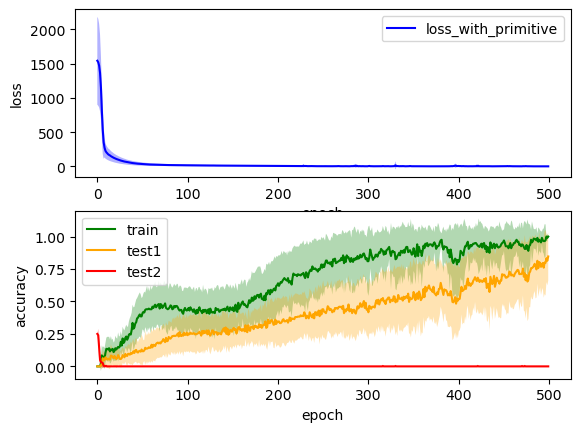

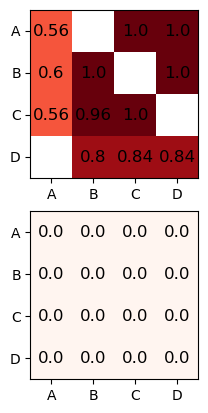

In [22]:
epochs = 500
num_sims = 32
hidden_size = 15
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_other(add, all_syms, cue_dict)+ primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

In [ ]:
# signed addition

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'D'), '=', 20], [('+', 'D'), ('+', 'A'), '=', 24], ['A', '=', 10], ['B', '=', 8], ['C', '=', 6], ['D', '=', 14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'B'), '=', 18], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'C'), '=', 14], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
run time:  1.8501325726509095
25


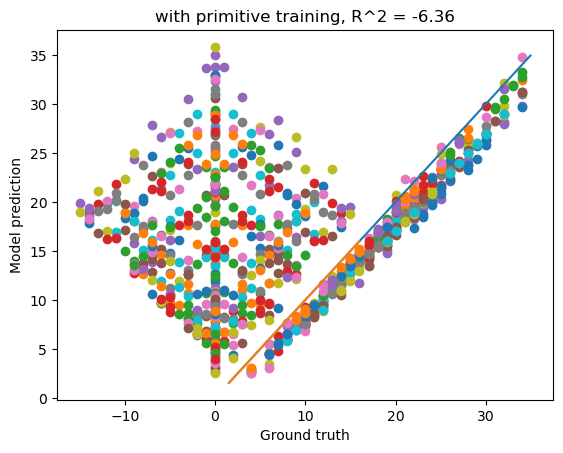

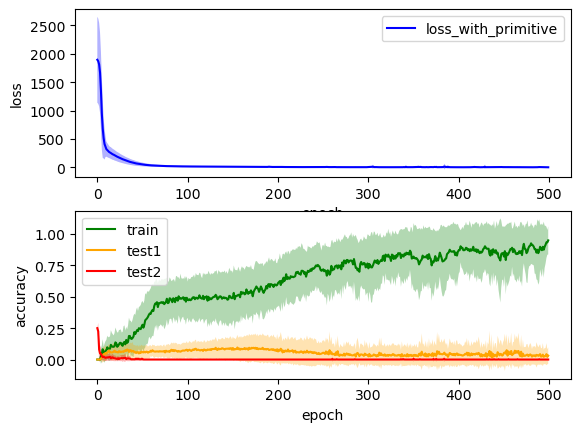

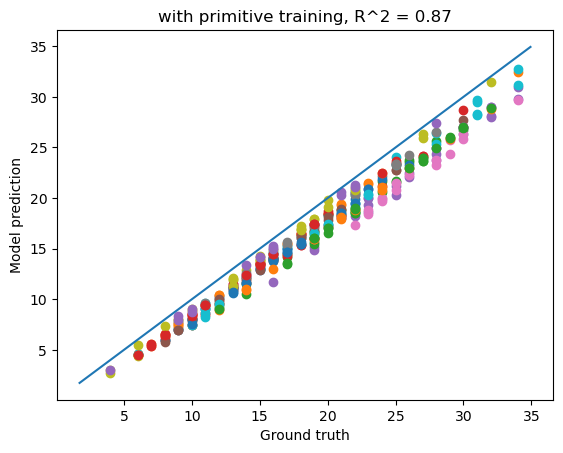

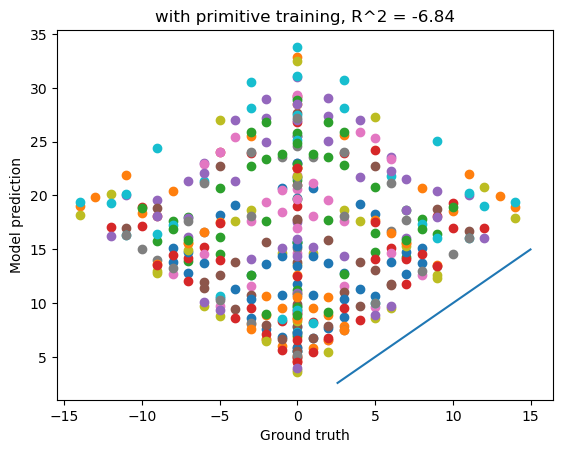

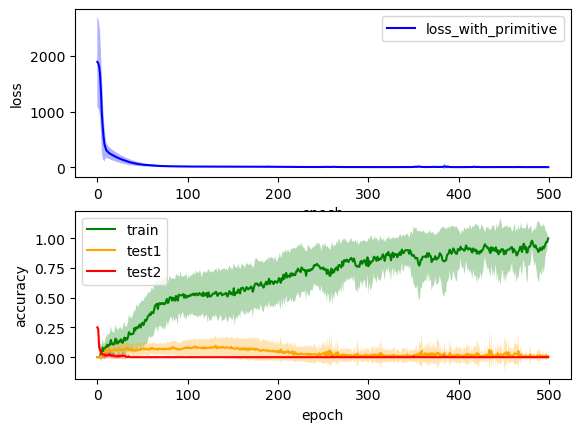

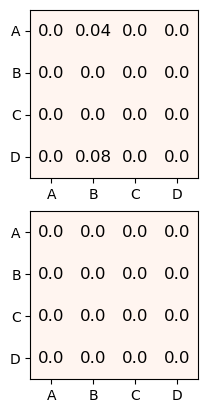

In [23]:
epochs = 500
num_sims = 32
hidden_size = 15
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_other_signed(add, all_syms, cue_dict)+ primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'D'), '=', 20], [('+', 'D'), ('+', 'A'), '=', 24], [('+', 'A'), '=', 10], [('+', 'B'), '=', 8], [('+', 'C'), '=', 6], [('+', 'D'), '=', 14]]
testseqs  [['A', ('+', 'A'), '=', 20], ['A', ('+', 'B'), '=', 18], ['A', ('+', 'C'), '=', 16], ['A', ('+', 'D'), '=', 24], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'C'), '=', 14], ['B', ('+', 'D'), '=', 22], ['C', ('+', 'A'), '=', 16], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['C', ('+', 'D'), '=', 20], ['D', ('+', 'A'), '=', 24], ['D', ('+', 'B'), '=', 22], ['D', ('+', 'C'), '=', 20], ['D', ('+', 'D'), '=', 28]]
run time:  2.0141421000162762
10


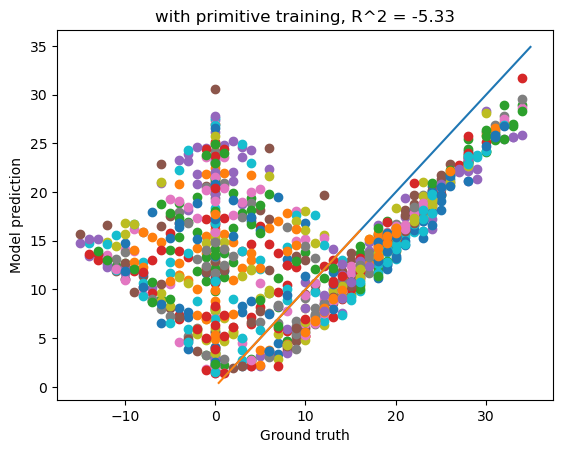

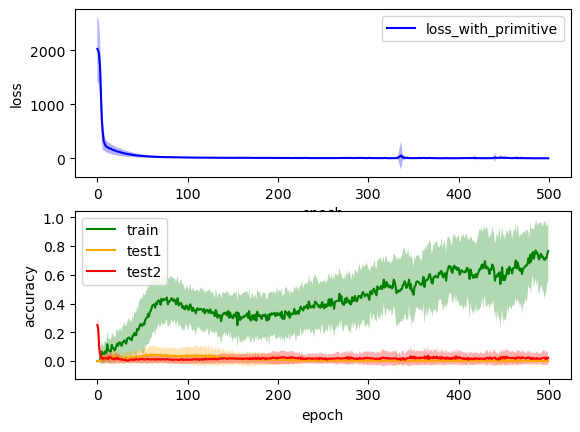

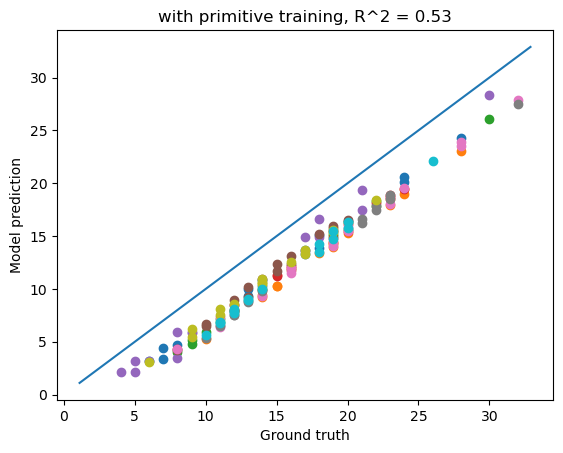

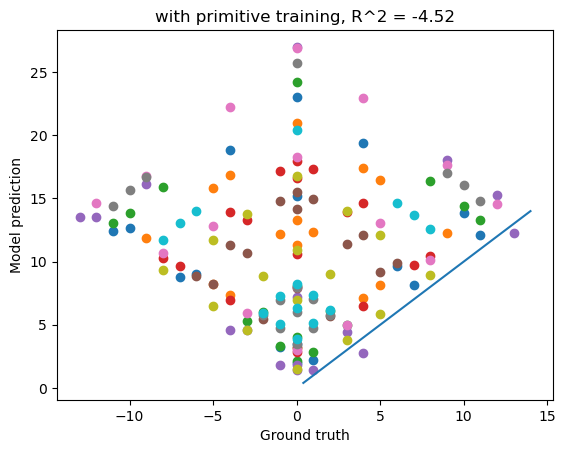

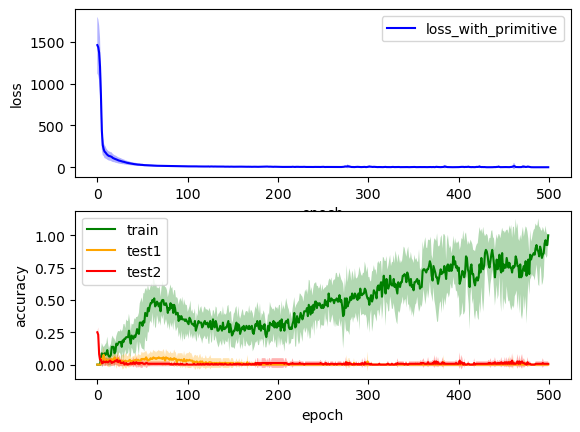

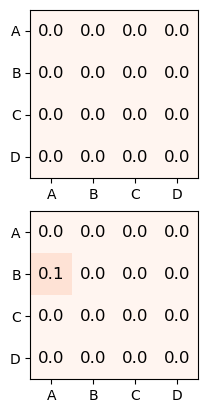

In [25]:
epochs = 500
num_sims = 32
hidden_size = 15
learningRate = 0.005
xavier_gain = 0.001

trainseqs = generate_other_signed(add, all_syms, cue_dict)+ pos_primitives
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

In [ ]:
# no primatives

In [ ]:
# primitives and - primitives

In [ ]:
# primitives, + and - primitives

In [ ]:
# + and - primitives

In [ ]:
# just +

In [ ]:
# just -

In [19]:
25*7*5

875

In [16]:
def generate_trials_signed(op, input_ids, init_values, cue_dict):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([('+', init),
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_other_signed(op, inputs, cue_dict):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [('+', inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


trainseqs  [[('+', 'A'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'D'), '=', 20], [('+', 'D'), ('+', 'A'), '=', 24], ['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 2], ['C', ('-', 'D'), '=', -8], ['D', ('-', 'A'), '=', 4], ['A', '=', 10], ['B', '=', 8], ['C', '=', 6], ['D', '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -8], [('-', 'C'), '=', -6], [('-', 'D'), '=', -14]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 20], [('+', 'A'), ('+', 'C'), '=', 16], [('+', 'A'), ('+', 'D'), '=', 24], [('+', 'B'), ('+', 'A'), '=', 18], [('+', 'B'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'D'), '=', 22], [('+', 'C'), ('+', 'A'), '=', 16], [('+', 'C'), ('+', 'B'), '=', 14], [('+', 'C'), ('+', 'C'), '=', 12], [('+', 'D'), ('+', 'B'), '=', 22], [('+', 'D'), ('+', 'C'), '=', 20], [('+', 'D'), ('+', 'D'), '=', 28]]
run time:  77.15421151717504
12


ValueError: '+' is not in list

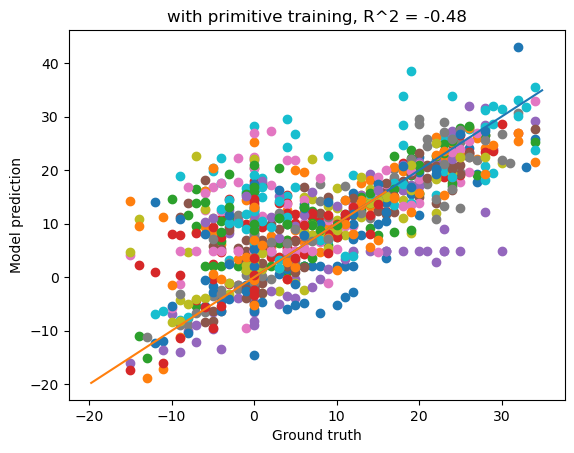

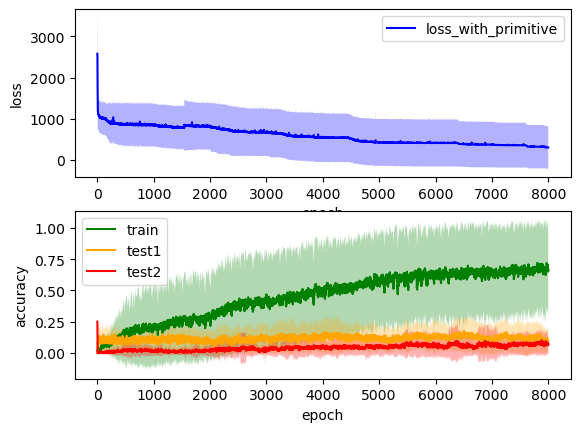

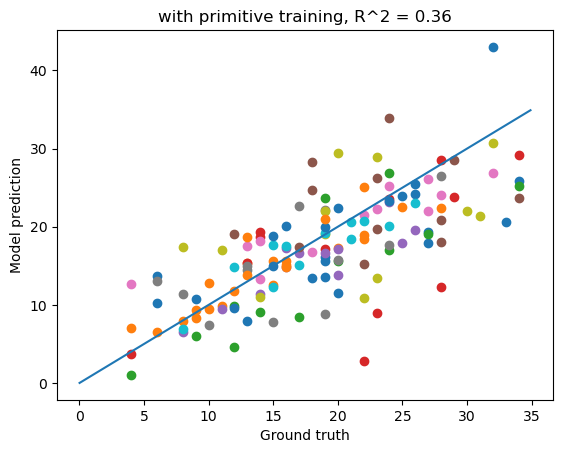

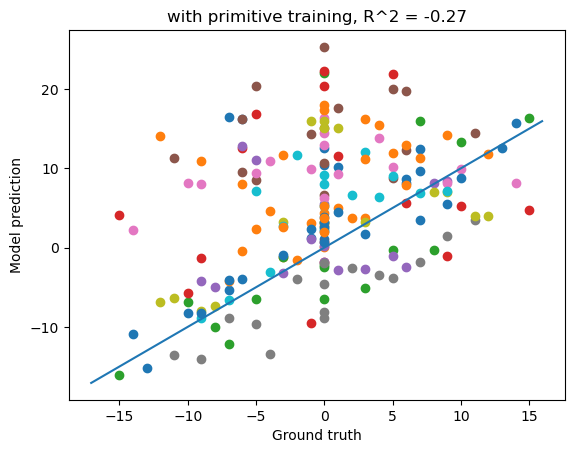

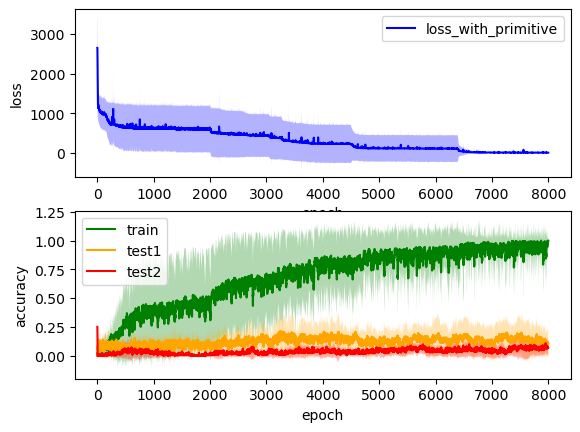

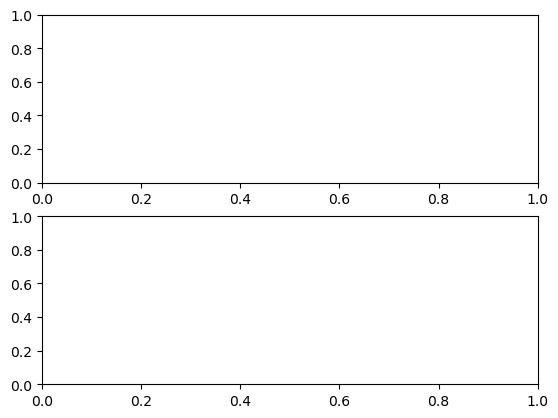

In [18]:
epochs = 8000
num_sims = 32
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

trainseqs = generate_other_signed(add, all_syms, cue_dict)+ generate_other(sub, all_syms, cue_dict)+ primitives + neg_primitives
testseqs_add = generate_trials_signed(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials_signed(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add if seq not in trainseqs]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs]

print('trainseqs ', trainseqs)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

In [20]:
res1['dfs1']

label       pred       acc
trial                                                    
['+', 'A', '+', 'A', '=']   6.333333   9.817009  0.166667
['+', 'B', '+', 'A', '=']  11.166667  12.379305  0.166667
['+', 'C', '+', 'A', '=']  14.750000  16.334117  0.166667
['+', 'C', '+', 'C', '=']  23.166667  23.600960  0.166667
['+', 'D', '+', 'C', '=']  26.333333  21.283582  0.166667
['+', 'A', '+', 'C', '=']  14.750000  15.771171  0.083333
['+', 'A', '+', 'D', '=']  17.916667  19.514275  0.083333
['+', 'B', '+', 'B', '=']  16.000000  11.810532  0.083333
['+', 'B', '+', 'D', '=']  22.750000  21.854182  0.083333
['+', 'C', '+', 'B', '=']  19.583333  15.740122  0.083333
['+', 'D', '+', 'B', '=']  22.750000  15.751695  0.000000
['+', 'D', '+', 'D', '=']  29.500000  24.651057  0.000000